<a href="https://colab.research.google.com/github/jhk990602/datapractice/blob/main/principal_component_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#과일 사진 데이터를 다운로드하여 넘파이 배열로
!wget https://bit.ly/fruits_300 -O fruits_300.npy
import numpy as np
fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

--2023-07-18 04:00:25--  https://bit.ly/fruits_300
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hongong-ml/raw/master/fruits_300.npy [following]
--2023-07-18 04:00:25--  https://github.com/rickiepark/hongong-ml/raw/master/fruits_300.npy
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hongong-ml/master/fruits_300.npy [following]
--2023-07-18 04:00:26--  https://raw.githubusercontent.com/rickiepark/hongong-ml/master/fruits_300.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443

In [2]:
from sklearn.decomposition import PCA #사이킷런은 sklearn.decomposition 모듈 아래 PCA 클래스로 주성분 분석 알고리즘 제공
pca = PCA(n_components=50) #PCA클래스의 객체를 만들 떄 n_components 매개변수에 주성분의 개수지정필요
pca.fit(fruits_2d) #비지도학습이기때문에 fit() 메서드에 타깃값 제공x

PCA(n_components=50)

In [3]:
print(pca.components_.shape) #n_components=50으로 지정했기 때문에 pca.components_배열의 첫 번째 차원이 50, 즉 50개의 주성분, 두번째 차원은 항상 원본 데이터의 특성 개수와 같은 10000개

(50, 10000)


In [4]:
#각 클러스터가 어떤 이미지를 나타냈는지 그림으로 출력하기 위한 유틸리티 함수
import matplotlib.pyplot as plt
def draw_fruits(arr, ratio =1):
  n = len(arr) #n은 샘플개수
  #한 줄에 10개씩 이미지를 그림, 샘플 개수를 10으로 나누어 전체 행 개수 계산
  rows = int(np.ceil(n/10))
  #행이 1개이면 열의 개수는 샘플개수, 그렇지 못하면 10개
  cols = n if rows < 2 else 10
  fig, axs = plt.subplots(rows, cols, figsize=(cols*ratio, rows*ratio), squeeze=False)
  for i in range(rows):
    for j in range(cols):
      if i * 10 + j < n: #n개까지만 그림
        axs[i,j].imshow(arr[i*10+j], cmap = 'gray_r')
      axs[i,j].axis('off')
  plt.show()

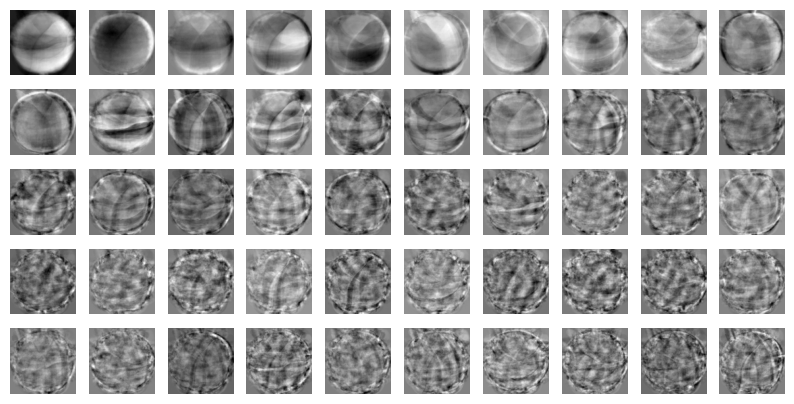

In [5]:
draw_fruits(pca.components_.reshape(-1,100,100))

주성분을 그림으로 나타낸것, 이 주성분은 원본 데이터에서 가장 분산이 큰 방향을 순서대로 나타낸 것.

In [6]:
#주성분을 찾았으므로 원본 데이터를 주성분에 투영하여 특성의 개수를 10000개에서 50개로 줄이기,
print(fruits_2d.shape)

(300, 10000)


In [7]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


10000개의 픽셀(특성)을 가진 300개의 이미지를, 50개의 주성분을 찾은 PCA모델을 사용해 이를 (300,50) 크기의 배열로 변환

In [9]:
#10000개의 특성을 50개로 줄여 어느정도 손실 발생, 하지만 분산이 큰 방향으로 데이터를 투영했기에 원본데이터 상당부분 재구성가능
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


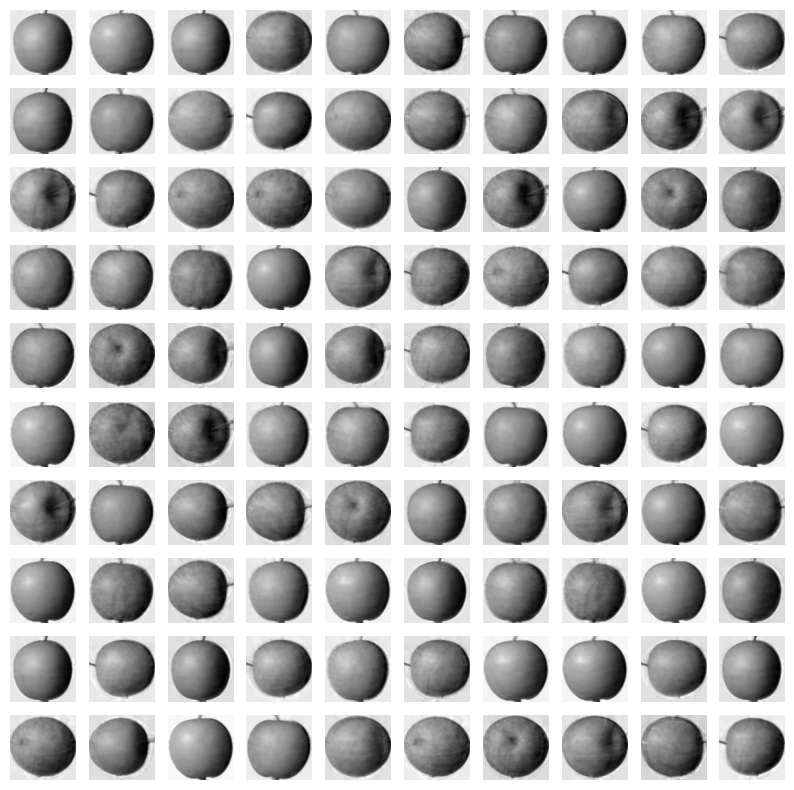

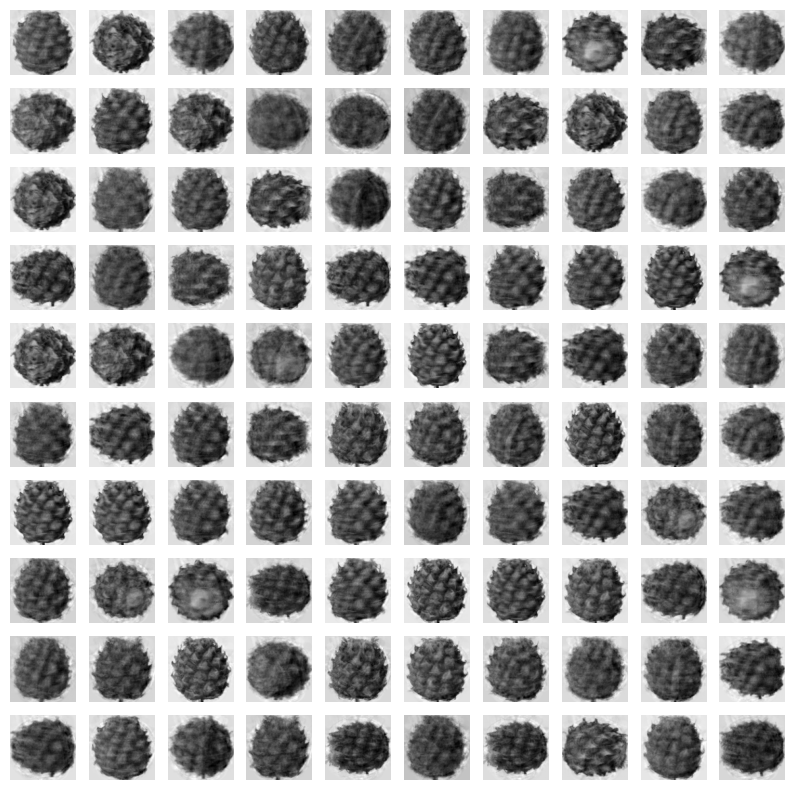

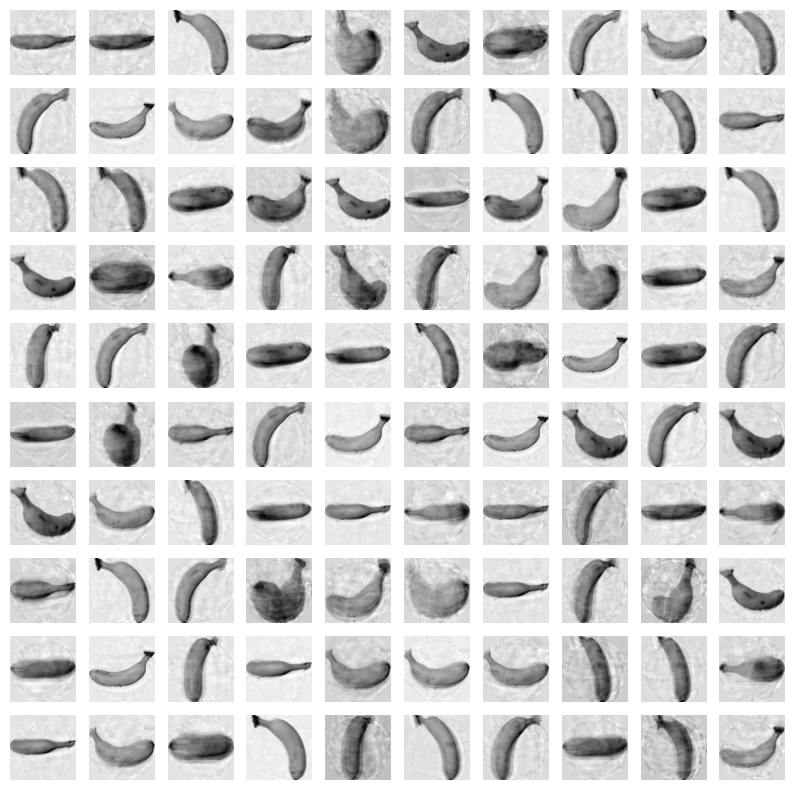

In [11]:
#복원된 특성을 100*100크기로 바꾸어 100개씩 나누어 출력
fruits_reconstruct = fruits_inverse.reshape(-1,100,100)
for start in [0,100,200]:
  draw_fruits(fruits_reconstruct[start:start+100])
  print("\n")

주성분이 원본 데이터의 분산을 얼마나 잘 나타내는지 기록한 값을 설명된 분산이라고함, PCA 클래스의 explained_variance_ratio_에 각 주성분의 설명된 분산 비율이 기록되어있음. 당연히 첫 번째 주성분의 설명된 분산이 가장큼

In [12]:
print(np.sum(pca.explained_variance_ratio_))

0.9215615358843413


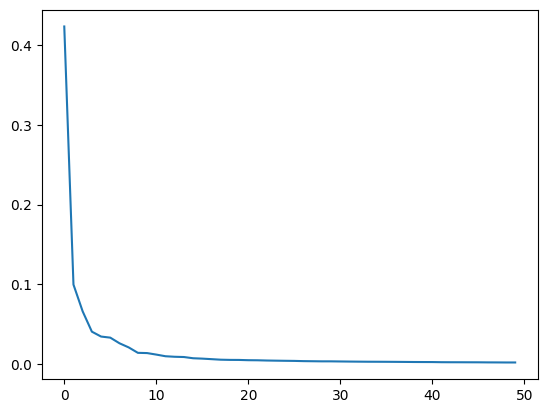

In [13]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [14]:
#PCA로 차원 축소된 데이터를 사용하여 지도학습모델훈련
#3개의 과일 사진을 분류해야 하므로 로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [15]:
#지도 학습 모델을 사용하려면 타깃값필요, 사과를 0, 파인애플을 1, 바나나를 2로 지정
target = np.array([0]*100+[1]*100+[2]*100)

In [18]:
#원본데이터인 fruits_2d 먼저, 로지스틱 회귀 모델에서 성능을 가늠해보기위해 cross_validate()로 교차검증
from sklearn.model_selection import cross_validate
scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
1.8197946548461914


In [19]:
#PCA로 축소한 fruits_pca를 사용했을 때와 비교
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

1.0
0.03963150978088379


PCA로 훈련 데이터의 차원을 축소하면 저장공간뿐만 아니라 머신러닝 모델의 훈련속도도 높일 수 있음

In [20]:
pca = PCA(n_components=0.5) #n_components 매개변수에 주성분의 개수지정이 아닌 원하는 설명된 분산의 비율을 입력가능
pca.fit(fruits_2d)

PCA(n_components=0.5)

In [22]:
print(pca.n_components_) #개의 특성만으로 원본 데이터에 있는 분산의50%를 표현가능

2


In [23]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [24]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9933333333333334
0.13841705322265624


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [25]:
#차원 축소된 데이터를 사용해 k-평균 알고리즘으로 클러스터 찾기
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3, random_state=42)
km.fit(fruits_pca)
print(np.unique(km.labels_, return_counts= True))

(array([0, 1, 2], dtype=int32), array([110,  99,  91]))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


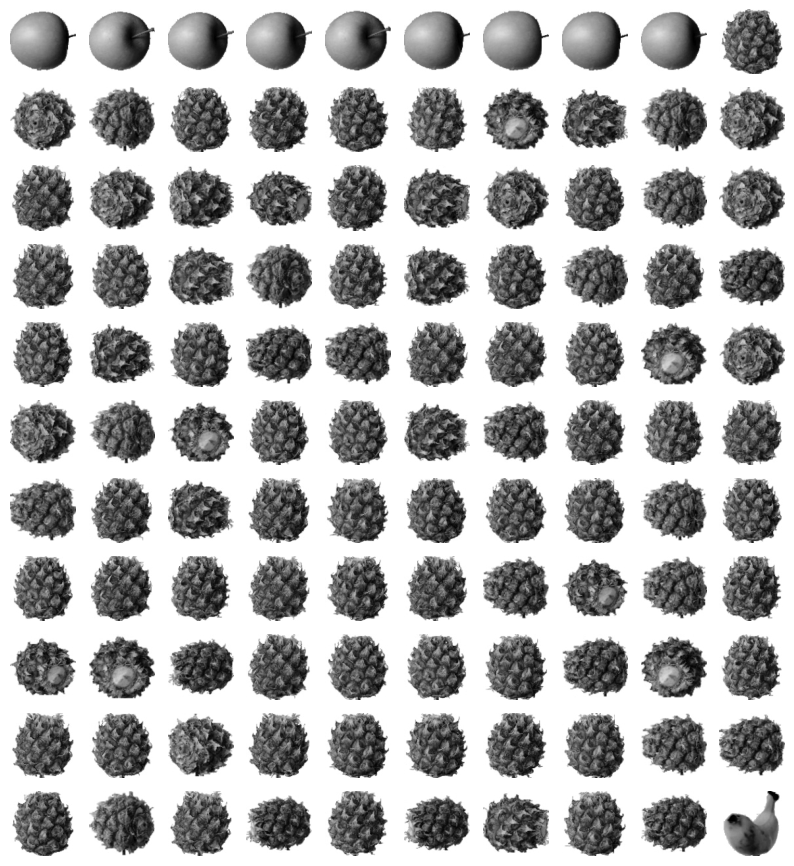

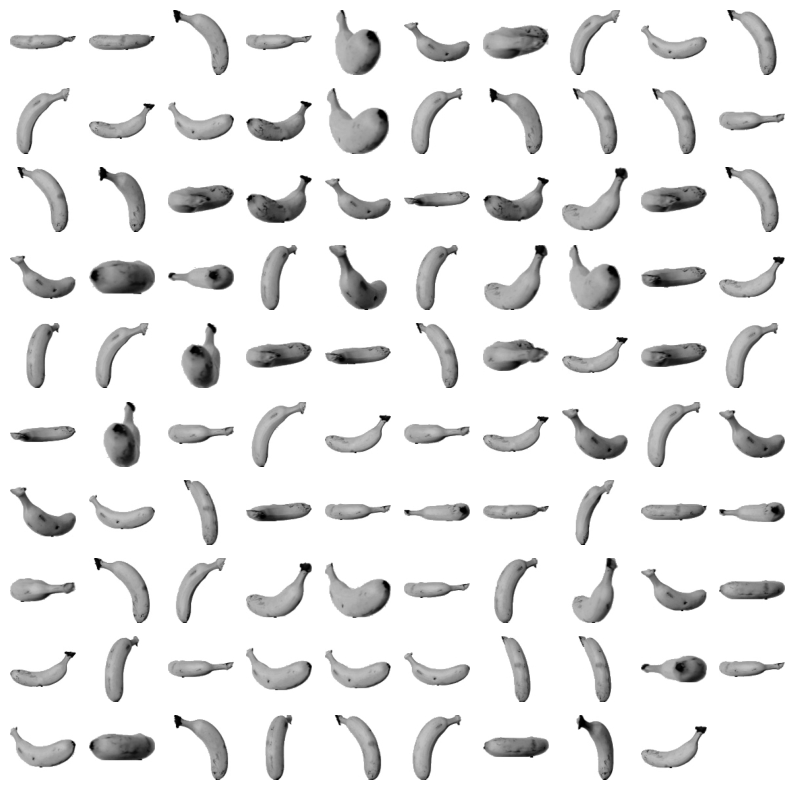

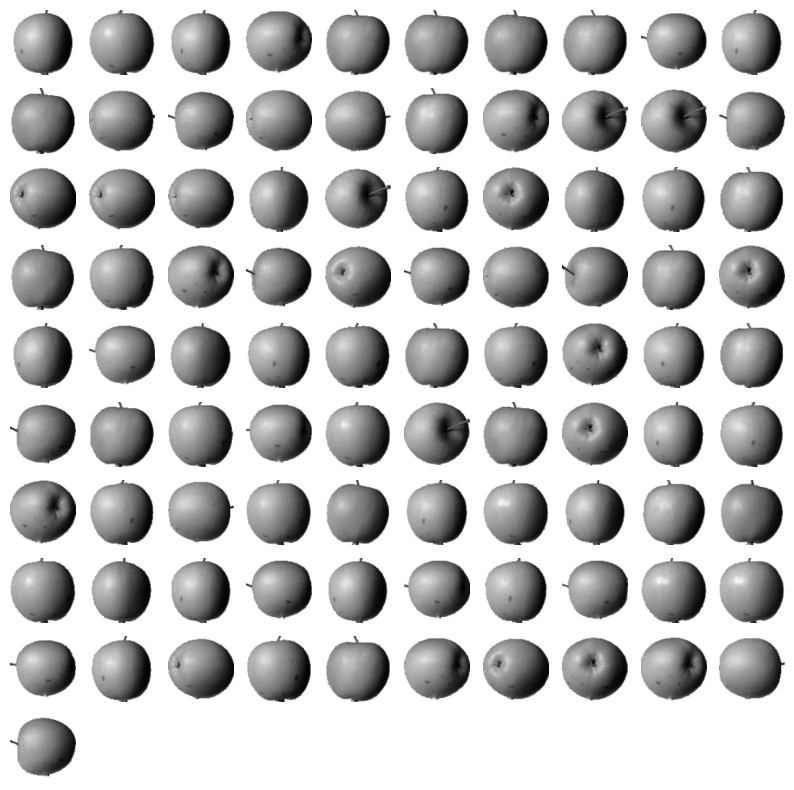

In [27]:
for label in range(0,3):
  draw_fruits(fruits[km.labels_ == label])
  print("\n")

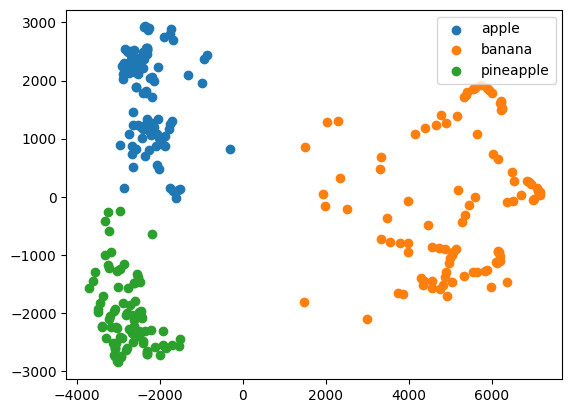

In [29]:
for label in range(0,3):
  data = fruits_pca[km.labels_ == label]
  plt.scatter(data[:,0], data[:,1])
plt.legend(['apple','banana','pineapple'])
plt.show()